# Projet de Séries temporelles linéaires


In [1]:
library(tseries)
library(forecast)
library(fUnitRoots)
library(car)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Loading required package: timeDate


Loading required package: timeSeries


Loading required package: fBasics


Loading required package: carData



Attaching package: ‘car’



The following object is masked from ‘package:fBasics’:

    densityPlot



## Partie 1 : Les données

,Date,Valeurs
1,1990-01,68.28
2,1990-02,74.69
3,1990-03,68.85
4,1990-04,70.54
5,1990-05,71.46
6,1990-06,69.79


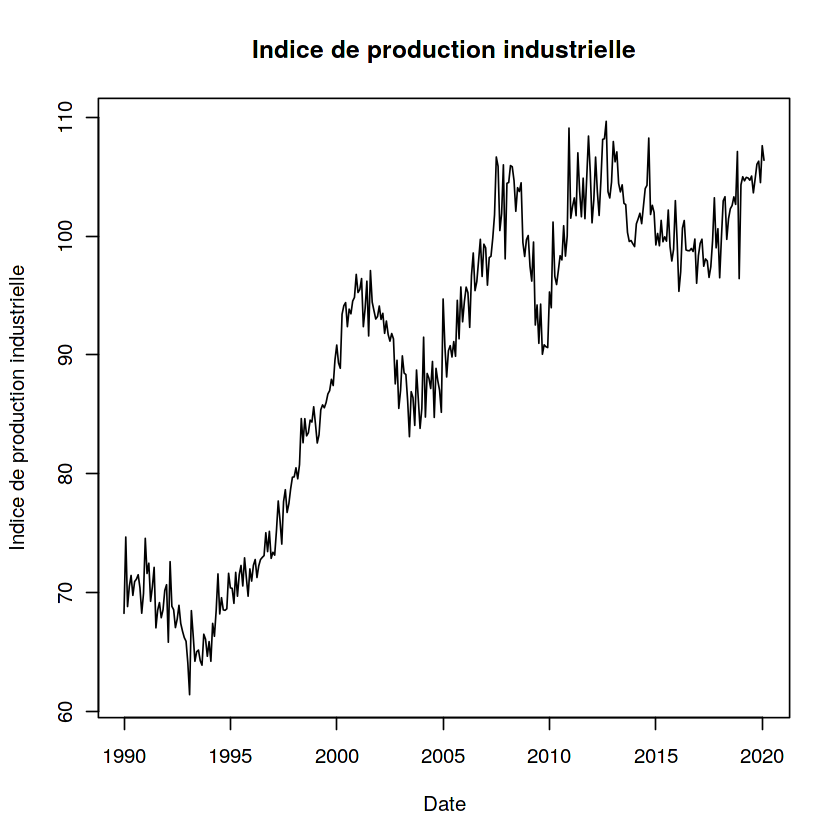

In [2]:
# Extraction et mise en forme des données :
data <- as.data.frame(read.csv("valeurs_mensuelles.csv", fileEncoding = "UTF-8", sep = ";"))
donnees <- as.matrix(data[-c(1, 2),c(1,2)])
colnames(donnees) <- c("Date","Valeurs")
donnees <- apply(donnees, 2, rev)
rownames(donnees) <- 1:dim(donnees)[1]
head(donnees)
s <- ts(as.numeric(donnees[,2]),start=1990,frequency=12)
n <- length(s)
plot(s,xlab='Date',ylab="Indice de production industrielle", main="Indice de production industrielle")

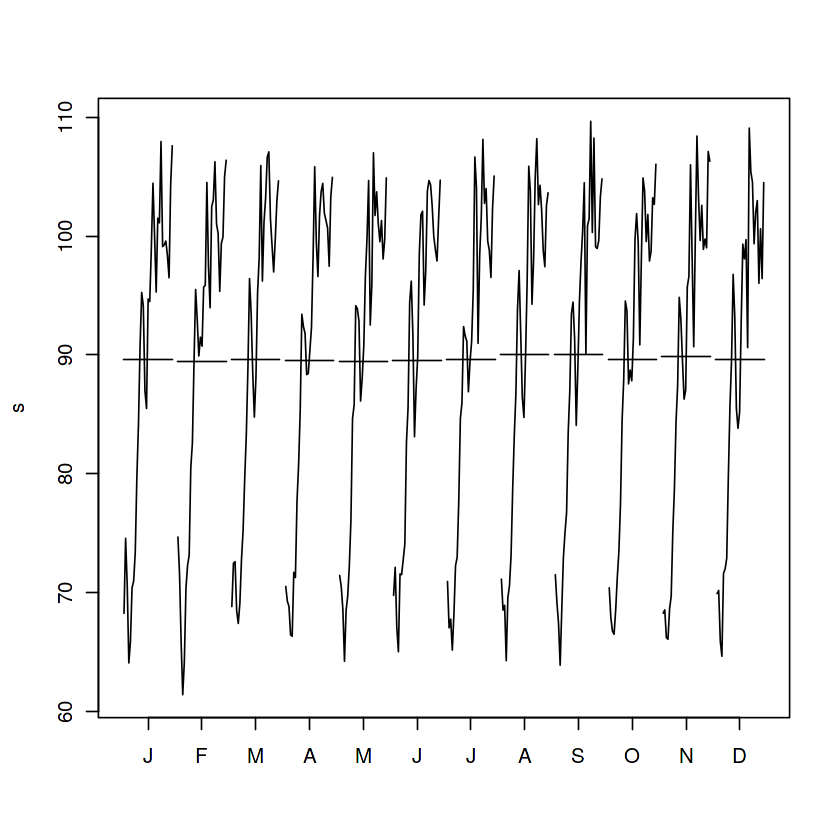

In [3]:
monthplot(s)
#les 12 chronogrammes mensuels sont à peu près identiques, ce qui confirme l'absence de saisonalité

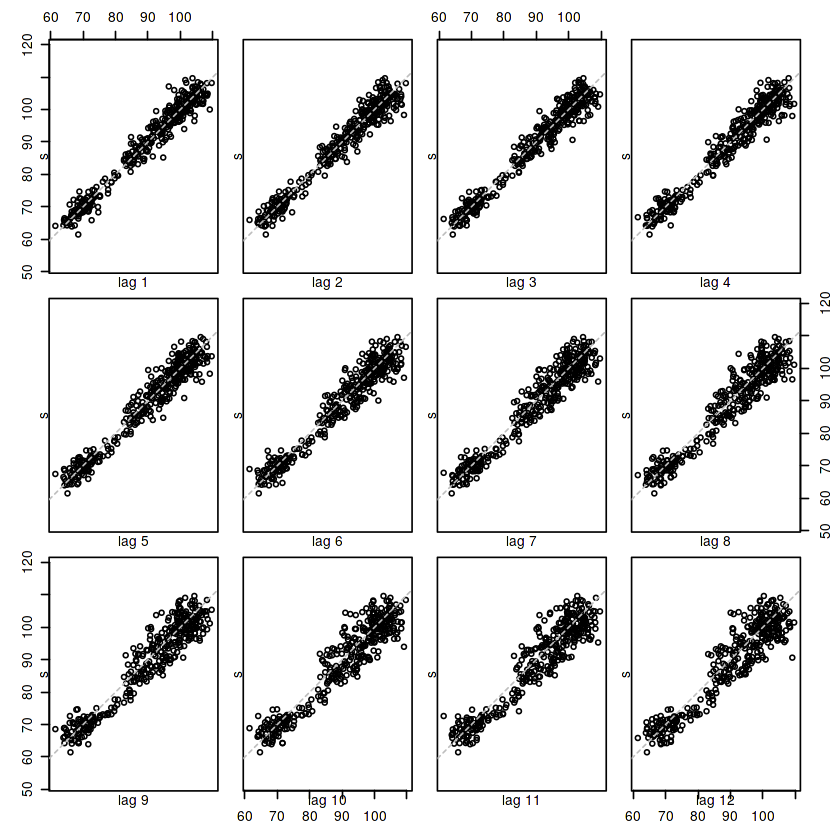

In [4]:
lag.plot(s,lags=12,layout=c(3,4),do.lines=FALSE)

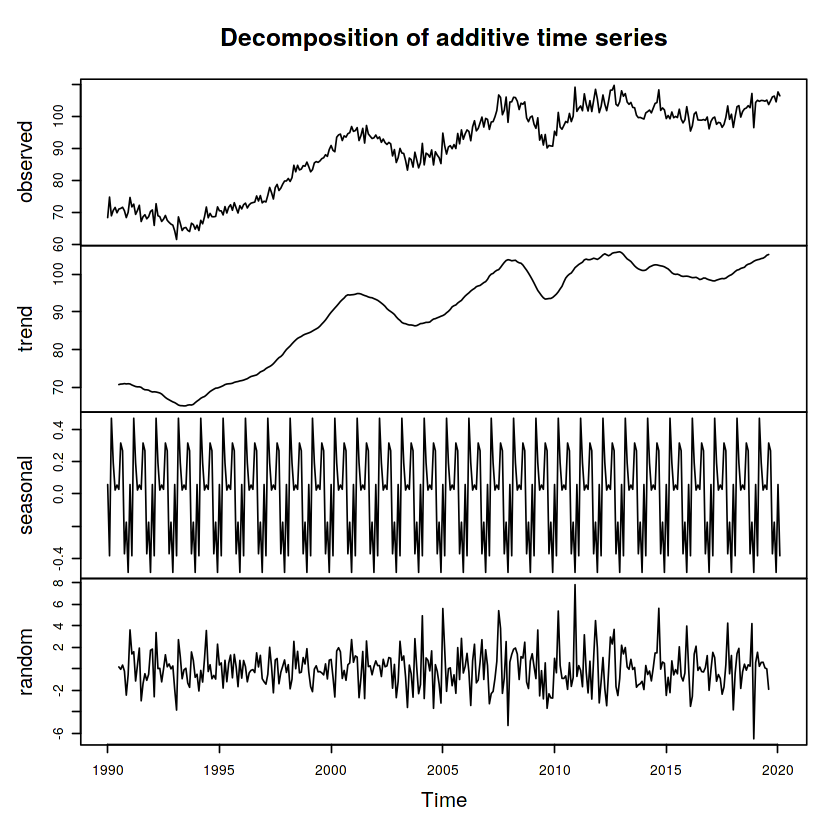

In [5]:
fit1 <- decompose(s)
plot(fit1)
#on peut voir que l'erreur ne semble pas varier au cours du temps ce qui indique l'adéquation du modele additif

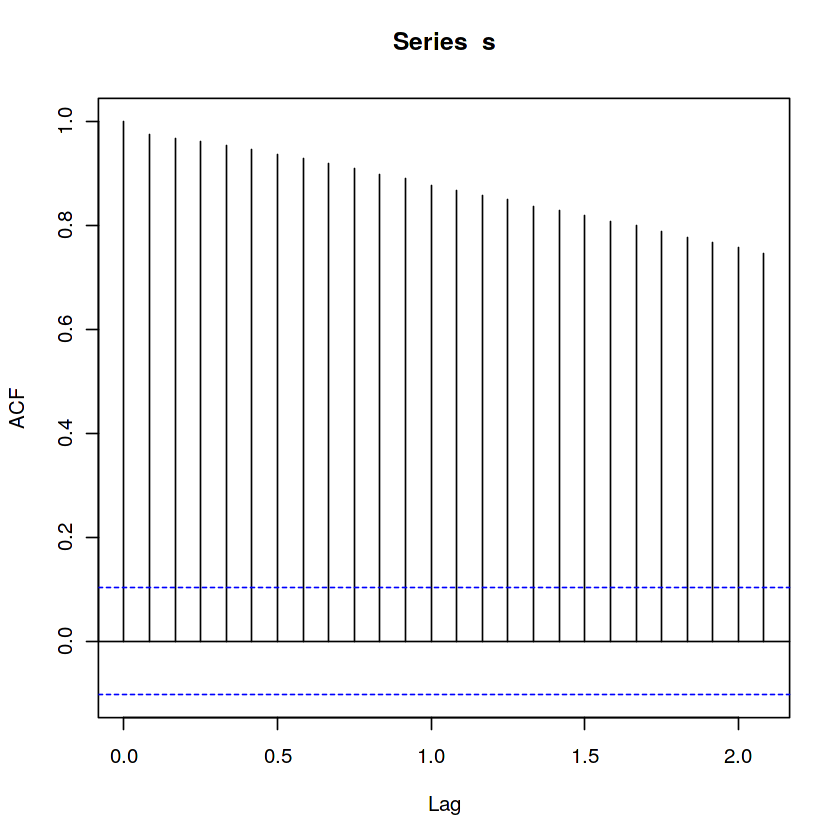

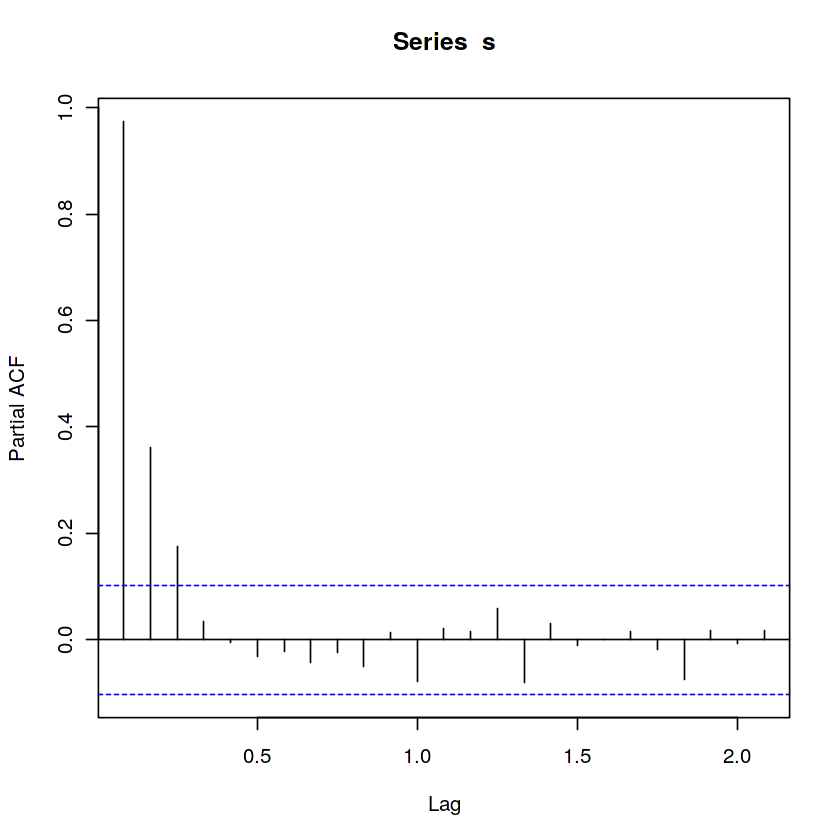

In [6]:
acf(s)
pacf(s)
# L'ACF montre que la série n'est pas stationnaire et qu'elle présente une tendance, mais ne montre pas de saisonnalité.

In [7]:
summary(lm(s ~ seq(1,n)))
# Le coefficient de la tendance linéaire est significatif, donc on effectue les tests de stationnarité avec tendance


Call:
lm(formula = s ~ seq(1, n))

Residuals:
     Min       1Q   Median       3Q      Max 
-12.1968  -4.7501  -0.5111   4.3738  13.6144 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 69.012769   0.609744  113.18   <2e-16 ***
seq(1, n)    0.113805   0.002911   39.09   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.789 on 360 degrees of freedom
Multiple R-squared:  0.8093,	Adjusted R-squared:  0.8088 
F-statistic:  1528 on 1 and 360 DF,  p-value: < 2.2e-16


In [8]:
kpss.test(s,null="Trend")
# Le test KPSS rejette au niveau 1% l'hypothèse de stationnarité de la série.

Warning message in kpss.test(s, null = "Trend"):
“p-value smaller than printed p-value”


	KPSS Test for Trend Stationarity

data:  s
KPSS Trend = 0.79116, Truncation lag parameter = 5, p-value = 0.01


In [9]:
LjungBoxtest <- function(X, k, fitdf=0) # Retourne les p-valeurs du test de LjungBox sur les k premiers retards de X
{
pvalues <- apply(matrix(1:k), 1, FUN=function(l) {
pval <- if (l<=fitdf) NA else Box.test(X, lag=l, type="Ljung-Box", fitdf=fitdf)$p.value
return(c("lag"=l,"pval"=pval))
})
return(t(pvalues))
}

In [10]:
ValidADF <- function(X,kmax,type){ # Tests ADF jusqu’à avoir des résidus non autocorrélés
k <- 0
pasautcor <- 0
while (pasautcor==0){
cat(paste0("ADF avec ",k, " lags: "))
adf <- adfTest(X,lags=k,type=type)
pvalues <- LjungBoxtest(adf@test$lm$residuals,24,fitdf=length(adf@test$lm$coefficients))[,2]
if (sum(pvalues<0.05,na.rm=T) == 0) {
pasautcor <- 1; cat("Les résidus ne sont pas auto-corrélés. Test ADF valide.\n")}
else cat("Les résidus sont auto-corrélés \n")
k <- k + 1
}
return(adf)
}
adf <- ValidADF(s,24,"ct")
adf
# Le test ADF ne rejette pas au seuil 5% la présence d'une racine unitaire.
# La serie est donc intégrée. On la différencie à l'ordre 1 :
x <- diff(s)

ADF avec 0 lags: 

Warning message in adfTest(X, lags = k, type = type):
“p-value smaller than printed p-value”

Les résidus sont auto-corrélés 
ADF avec 1 lags: Les résidus sont auto-corrélés 
ADF avec 2 lags: Les résidus sont auto-corrélés 
ADF avec 3 lags: Les résidus sont auto-corrélés 
ADF avec 4 lags: Les résidus sont auto-corrélés 
ADF avec 5 lags: Les résidus sont auto-corrélés 
ADF avec 6 lags: Les résidus sont auto-corrélés 
ADF avec 7 lags: Les résidus sont auto-corrélés 
ADF avec 8 lags: Les résidus sont auto-corrélés 
ADF avec 9 lags: Les résidus sont auto-corrélés 
ADF avec 10 lags: Les résidus sont auto-corrélés 
ADF avec 11 lags: Les résidus ne sont pas auto-corrélés. Test ADF valide.



Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 11
  STATISTIC:
    Dickey-Fuller: -2.4942
  P VALUE:
    0.3683 

Description:
 Sun May 10 19:17:11 2020 by user: 


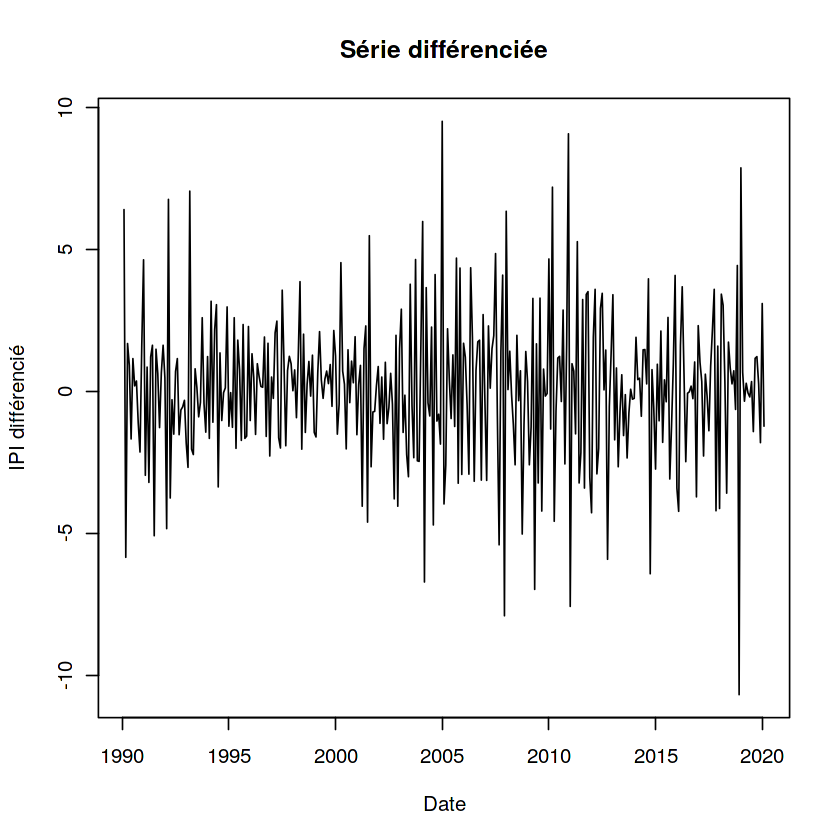

In [11]:
plot(x,xlab='Date',ylab="IPI différencié", main="Série différenciée")

In [12]:
# La série différenciée ne semble pas présenter de constante ou tendance. On le vérifie avec une régression linéaire :
summary(lm(x ~ seq(1,length(x))))
# Les coefficients associés à la constante et à la tendance sont non significatifs au seuil 5%


Call:
lm(formula = x ~ seq(1, length(x)))

Residuals:
     Min       1Q   Median       3Q      Max 
-10.7496  -1.5795   0.1378   1.3991   9.4143 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)
(Intercept)        0.1446759  0.2803562   0.516    0.606
seq(1, length(x)) -0.0002164  0.0013423  -0.161    0.872

Residual standard error: 2.658 on 359 degrees of freedom
Multiple R-squared:  7.237e-05,	Adjusted R-squared:  -0.002713 
F-statistic: 0.02598 on 1 and 359 DF,  p-value: 0.872


In [13]:
kpss.test(x,null="Level")
# Le test KPSS ne rejette pas la stationnarité de la série différenciée

Warning message in kpss.test(x, null = "Level"):
“p-value greater than printed p-value”


	KPSS Test for Level Stationarity

data:  x
KPSS Level = 0.05799, Truncation lag parameter = 5, p-value = 0.1


In [14]:
# Test d'hétéroscédasticité
lmtest::bptest(lm(x ~ seq(1,length(x))))
# On ne rejette pas l'homoscédasticité de X au niveau 5%


	studentized Breusch-Pagan test

data:  lm(x ~ seq(1, length(x)))
BP = 2.9729, df = 1, p-value = 0.08467


In [15]:
suppressWarnings(
    adf <- ValidADF(x,50,"nc"))
adf
# Le test ADF rejette au seuil 1% la présence d'une racine unitaire.
# La serie différenciée est donc stationnaire, c'est-à-dire que la série originale s est I(1)

ADF avec 0 lags: Les résidus sont auto-corrélés 
ADF avec 1 lags: Les résidus sont auto-corrélés 
ADF avec 2 lags: Les résidus ne sont pas auto-corrélés. Test ADF valide.



Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 2
  STATISTIC:
    Dickey-Fuller: -16.2181
  P VALUE:
    0.01 

Description:
 Sun May 10 19:17:11 2020 by user: 


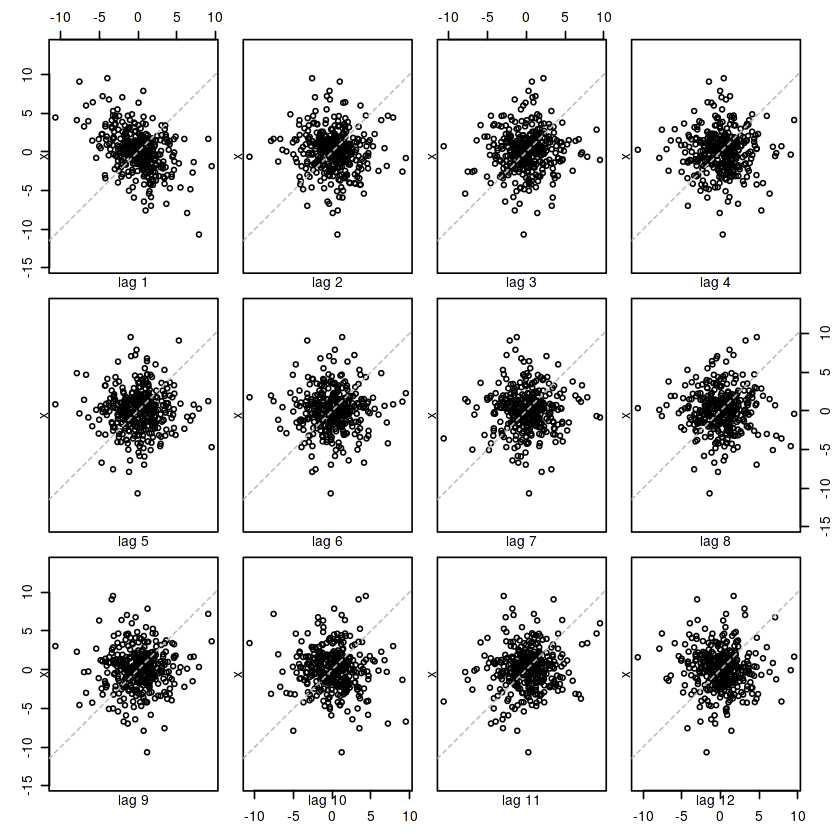

In [16]:
lag.plot(x,lags=12,layout=c(3,4),do.lines=FALSE)

## Partie 2 : Modèles ARMA

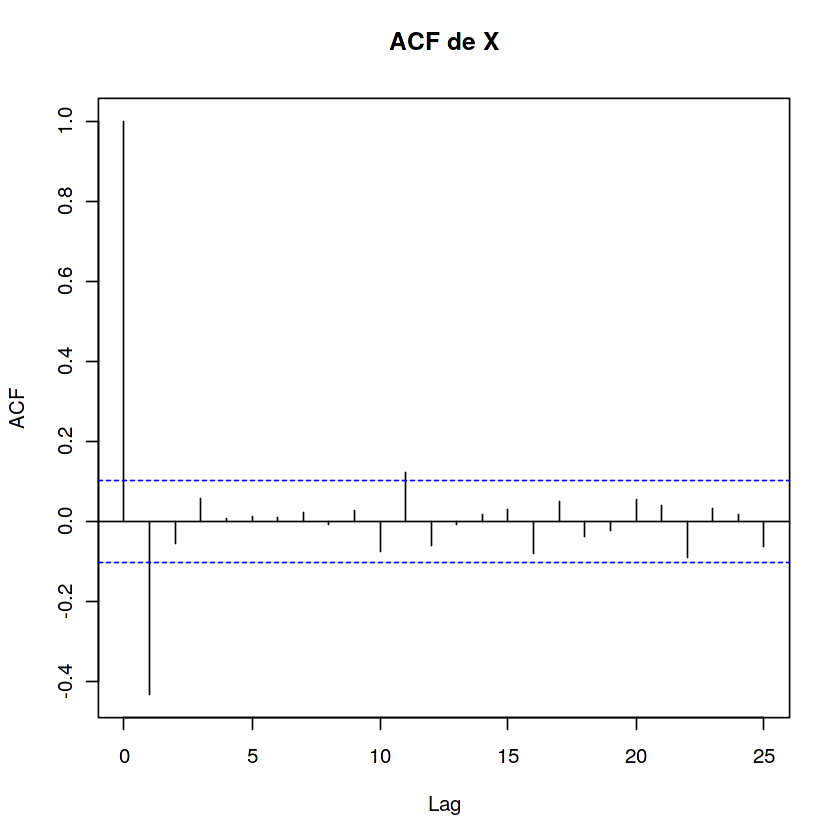

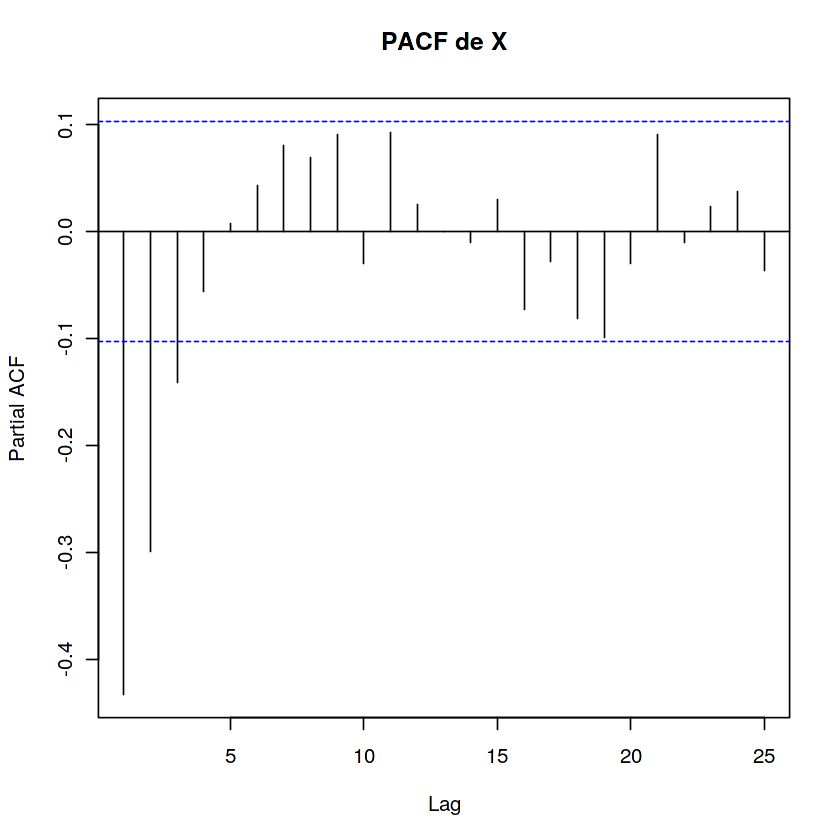

In [17]:
#####--   Partie 2 : Modèles ARMA   --#####

acf(as.numeric(x), main="ACF de X")
# L'ACF est seulement significatif à l'ordre 1. On note un léger dépassement au lag 11 mais on suppose qu'il est dû au hasard
# On a donc q_max=1
pacf(as.numeric(x),main="PACF de X")
# Le PACF est significatif jusqu'à l'ordre 3, donc p_max=3

In [18]:
# Tests de validité des modèles :
pmax <- 3
qmax <- 1
valide <- matrix(nrow=pmax+1,ncol=qmax+1)
for (p in 0:pmax){
    for (q in 0:qmax){
        model <- arima(x, order = c(p,0,q))
        valide[p+1,q+1] <- all(LjungBoxtest(model$residuals,24,fitdf=p+q)[-c(1:(p+q)),2]>0.05)
    }
}
rownames(valide) <- paste("p=",0:pmax)
colnames(valide) <- paste("q=",0:qmax)

cat("Validité des modèles :")
valide

Validité des modèles :

,q= 0,q= 1
p= 0,FALSE,TRUE
p= 1,FALSE,TRUE
p= 2,FALSE,TRUE
p= 3,TRUE,TRUE


In [19]:
# Tests de sigificativité des coefficients :
significatif <- matrix(nrow=pmax+1,ncol=qmax+1)
for (p in 0:pmax){
    for (q in 0:qmax){
        model <- arima(x, order = c(p,0,q))
        df <- length(x)-p-q-1
        coef <- model$coef
        se <- sqrt(diag(model$var.coef))
        t <- coef/se
        pval <- ((1-pt(abs(t),df))*2)
        if (p==0 & q==0) {significatif[p+1,q+1] <- (pval[1] < 0.05)}
        else if (q==0 | p==0) {significatif[p+1,q+1] <- (pval[p+q] < 0.05)}
        else {significatif[p+1,q+1] <- ( (pval[p] < 0.05) & (pval[q] < 0.05)) }
    }
}
rownames(significatif) <- paste("p=",0:pmax)
colnames(significatif) <- paste("q=",0:qmax)

cat("Significativité des modèles :")
significatif

Significativité des modèles :

,q= 0,q= 1
p= 0,FALSE,TRUE
p= 1,TRUE,FALSE
p= 2,TRUE,TRUE
p= 3,TRUE,FALSE


In [20]:
# Tests de nullité des autocorrélations des résidus :
autocorr_res <- matrix(nrow=pmax+1,ncol=qmax+1)
for (p in 0:pmax){
    for (q in 0:qmax){
        model <- arima(x, order = c(p,0,q))
        acf_res <- acf(model$residuals, plot=FALSE)
        pacf_res <- pacf(model$residuals, plot=FALSE)
        autocorr_res[p+1,q+1] <- all(abs(acf_res$acf)[-1] < qnorm((1 + 0.95)/2)/sqrt(n-1)) & all(abs(pacf_res$acf)[-1] < qnorm((1 + 0.95)/2)/sqrt(n-1))
    }
}
rownames(autocorr_res) <- paste("p=",0:pmax)
colnames(autocorr_res) <- paste("q=",0:qmax)

cat("Tests de nullité des autocorrélations des résidus :")
autocorr_res

Tests de nullité des autocorrélations des résidus :

,q= 0,q= 1
p= 0,FALSE,FALSE
p= 1,FALSE,FALSE
p= 2,FALSE,FALSE
p= 3,FALSE,FALSE


In [21]:
# Ce dernier critère est trop restrictif, il ne valide aucun modèle
# On le change en utilisant l'intervalle de confiance à 96.5% au lieu de 95% pour tester la nullité des autocorrélations des résidus
autocorr_res <- matrix(nrow=pmax+1,ncol=qmax+1)
for (p in 0:pmax){
    for (q in 0:qmax){
        model <- arima(x, order = c(p,0,q))
        acf_res <- acf(model$residuals, plot=FALSE)
        pacf_res <- pacf(model$residuals, plot=FALSE)
        autocorr_res[p+1,q+1] <- all(abs(acf_res$acf)[-1] < qnorm((1 + 0.965)/2)/sqrt(n-1)) & all(abs(pacf_res$acf)[-1] < qnorm((1 + 0.965)/2)/sqrt(n-1))
    }
}
rownames(autocorr_res) <- paste("p=",0:pmax)
colnames(autocorr_res) <- paste("q=",0:qmax)

cat("Tests de nullité des autocorrélations des résidus :")
autocorr_res

Tests de nullité des autocorrélations des résidus :

,q= 0,q= 1
p= 0,FALSE,TRUE
p= 1,FALSE,TRUE
p= 2,FALSE,TRUE
p= 3,FALSE,FALSE


In [22]:
# On résume les résultats de tous les tests de validité et de significativité :
cat("Tous les tests :")
valide & significatif & autocorr_res

Tous les tests :

,q= 0,q= 1
p= 0,FALSE,TRUE
p= 1,FALSE,FALSE
p= 2,FALSE,TRUE
p= 3,FALSE,FALSE


lag,pval
1,NA
2,0.33715051
3,0.24766009
4,0.19641014
5,0.14686783
6,0.11077680
7,0.08513368
8,0.10546015
9,0.12774303
10,0.18011220


Coefficients : 


ma1  intercept 
-0.5720459  0.1001345

P-valeurs : 


ma1  intercept 
0.00000000 0.05162589

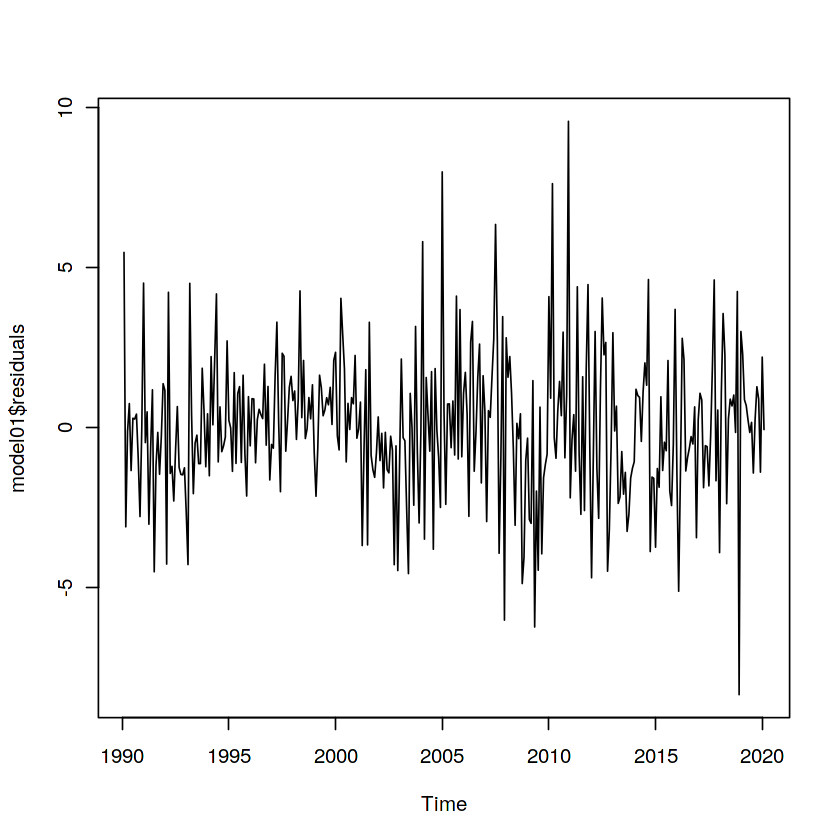

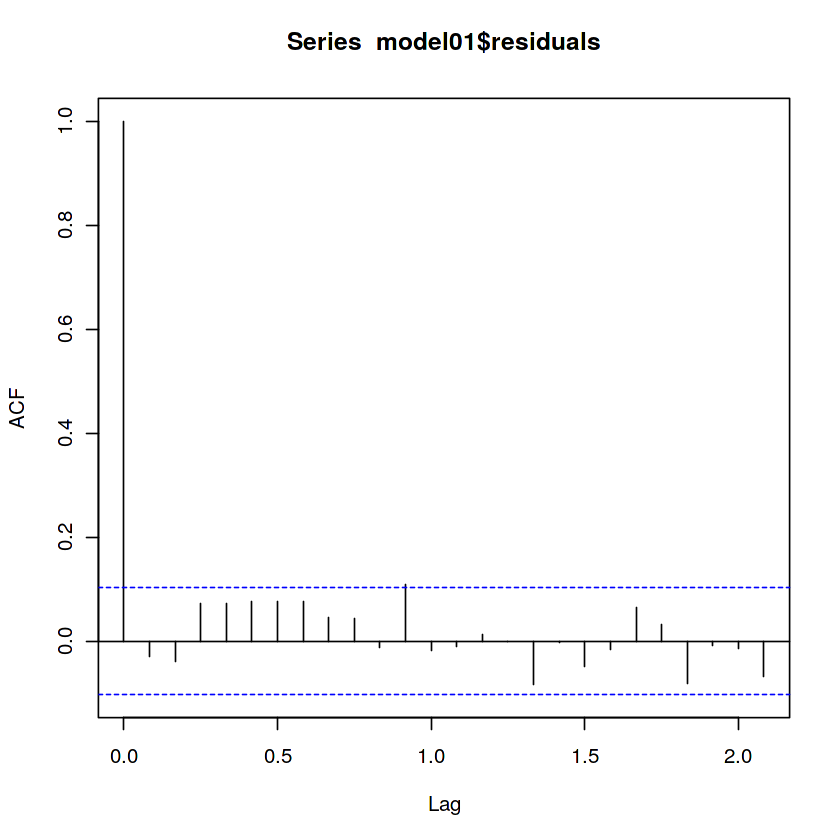

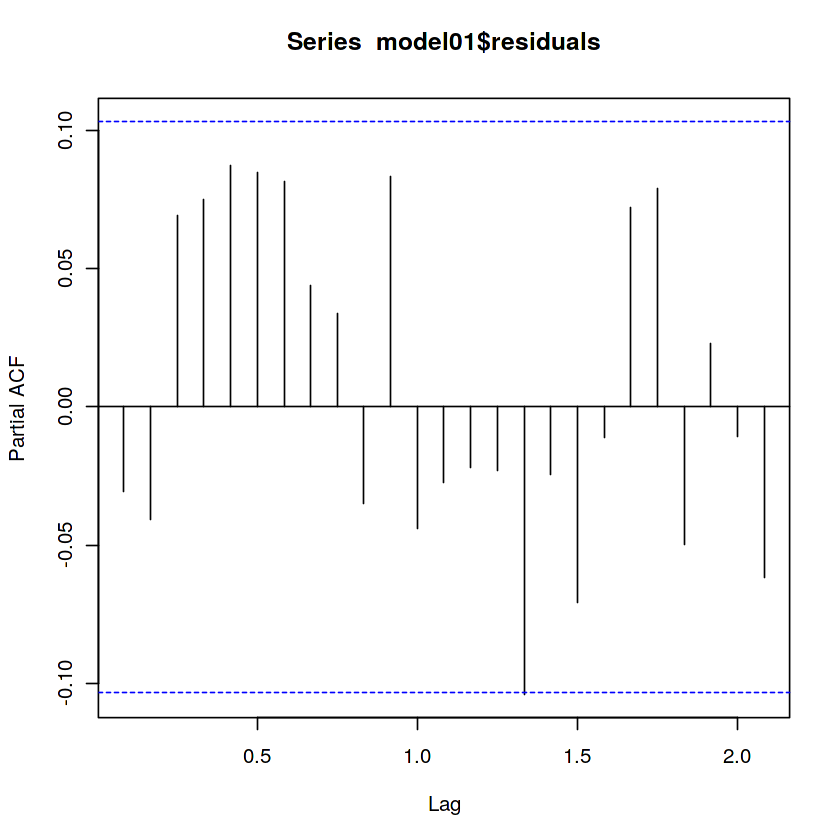

In [23]:
# Cela a permis de sélectionner deux modèles valides et ajustés : Les modèles ARMA(0,0,1) et ARIMA(2,0,1)
# Vérifions ces modèles
model01 <- arima(x, order=c(0,0,1))
LjungBoxtest(model01$residuals,24,fitdf=1)
df <- length(x)-1
coef <- model01$coef
se <- sqrt(diag(model01$var.coef))
t <- coef/se
pval <- ((1-pt(abs(t),df))*2)
cat("Coefficients : \n")
coef
cat("P-valeurs : \n")
pval
plot(model01$residuals)
acf(model01$residuals)
pacf(model01$residuals)
# On constate un très léger dépassement sur les autocorrélogrammes, c'est pourquoi ce modèle ne passait pas le test à 95% mais passait le test à 96.5%. Autrement, modèle est effectivement valide et bien ajusté et les résidus ressemblent à un bruit blanc.

lag,pval
1,NA
2,NA
3,NA
4,0.3644389
5,0.2213461
6,0.1593082
7,0.1175315
8,0.1636340
9,0.1933906
10,0.2710456


Coefficients : 


ar1        ar2        ma1  intercept 
-0.2311327 -0.1593465 -0.3796885  0.1001376

P-valeurs : 


ar1          ar2          ma1    intercept 
0.0470538511 0.0389090735 0.0006126978 0.0598392411

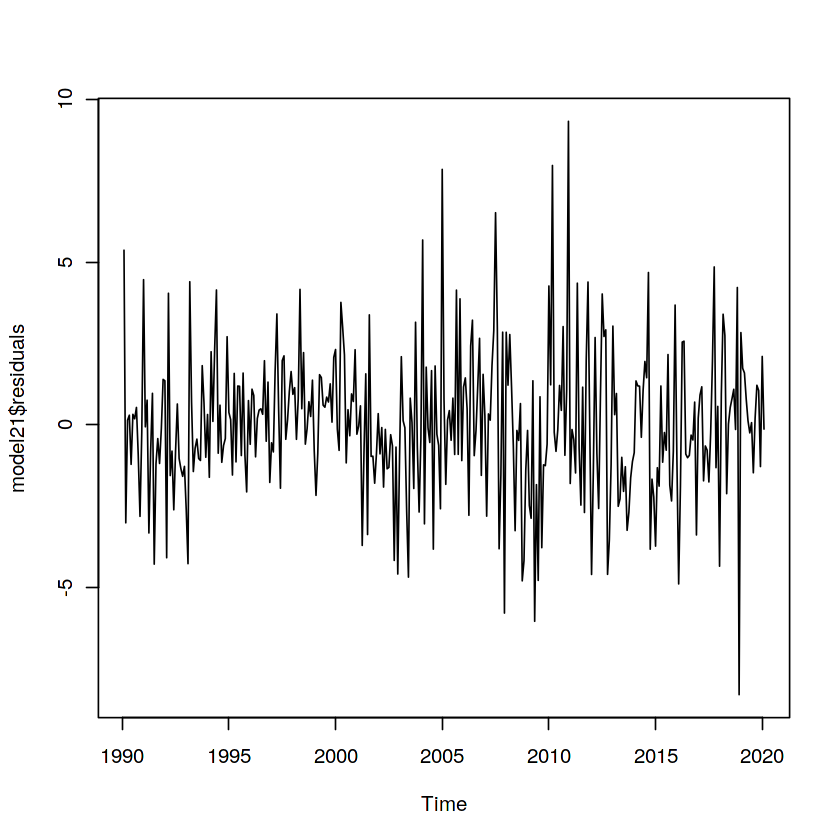

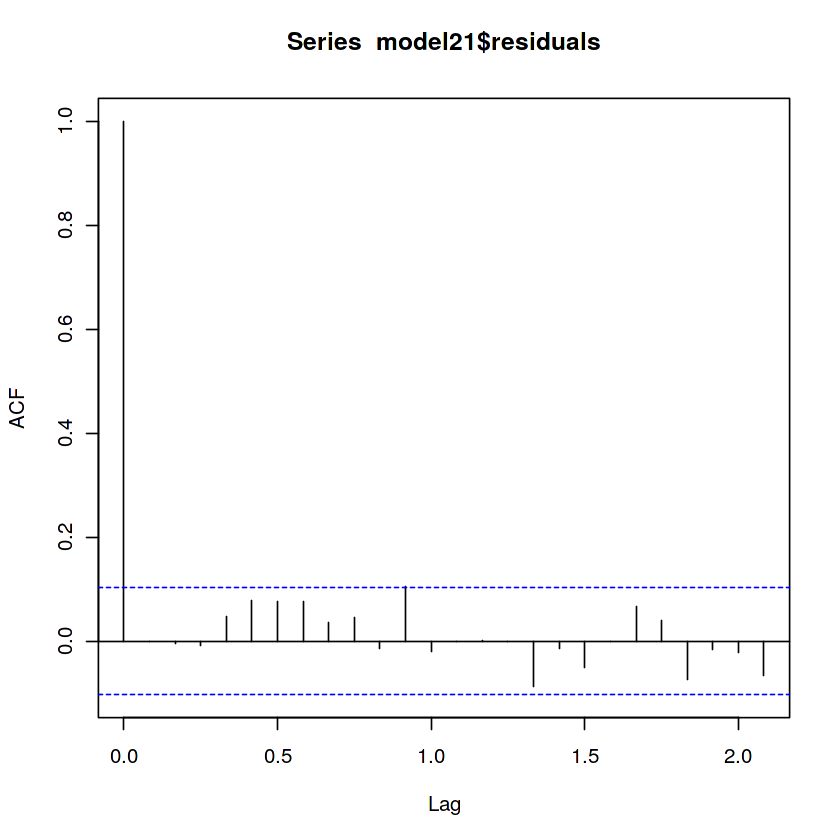

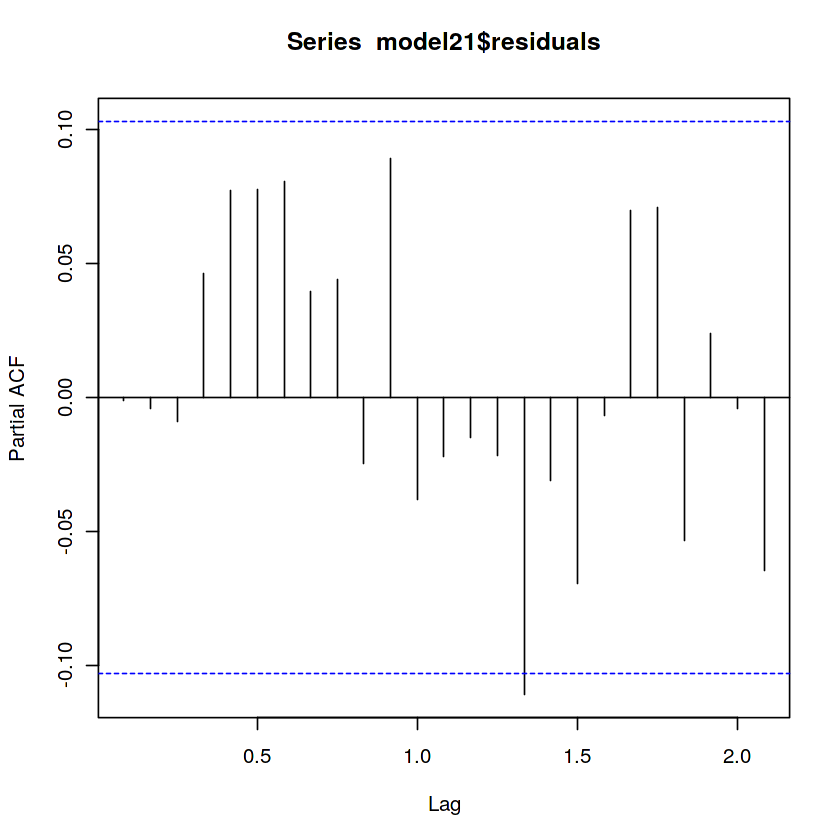

In [24]:
# On vérifie le modèle ARMA(2,1) :
model21 <- arima(x, order=c(2,0,1))
LjungBoxtest(model21$residuals,24,fitdf=3)
df <- length(x)-3
coef <- model21$coef
se <- sqrt(diag(model21$var.coef))
t <- coef/se
pval <- ((1-pt(abs(t),df))*2)
cat("Coefficients : \n")
coef
cat("P-valeurs : \n")
pval
plot(model21$residuals)
acf(model21$residuals)
pacf(model21$residuals)
# Il y a également un léger dépassement de l'intervalle de confiance mais sinon le modèle semble valide et bien ajusté.

In [25]:
# On compare les deux modèles maintenant par les criteres d'information AIC et BIC
pmax <- 3
qmax <- 1
liste_aic <- matrix(nrow=pmax+1,ncol=qmax+1)
liste_bic <- matrix(nrow=pmax+1,ncol=qmax+1)
for (p in 0:pmax){
    for (q in 0:qmax){
        model <- arima(x, order = c(p,0,q))
        liste_aic[p+1,q+1] <- AIC(model)
        liste_bic[p+1,q+1] <- AIC(model, k = log(length(x)))
    }
}
rownames(liste_aic) <- paste("p=",0:pmax)
colnames(liste_aic) <- paste("q=",0:qmax)
rownames(liste_bic) <- paste("p=",0:pmax)
colnames(liste_bic) <- paste("q=",0:qmax)

cat("AIC :")
liste_aic  # le meilleur modèle est ARMA(2,1)
cat("BIC :")
liste_bic  # le meilleur modèles est ARMA(0,1)

AIC :

,q= 0,q= 1
p= 0,1732.262,1622.174
p= 1,1658.130,1623.255
p= 2,1626.593,1621.269
p= 3,1621.454,1622.671


BIC :

,q= 0,q= 1
p= 0,1740.040,1633.841
p= 1,1669.797,1638.810
p= 2,1642.148,1640.714
p= 3,1640.899,1646.005


Modèle ARMA(0,1) :


	Jarque Bera Test

data:  model01$residuals
X-squared = 40.751, df = 2, p-value = 1.416e-09



	Shapiro-Wilk normality test

data:  model01$residuals
W = 0.98153, p-value = 0.0001399


[1] 251 347

Modèle ARMA(2,1) :


	Jarque Bera Test

data:  model21$residuals
X-squared = 40.836, df = 2, p-value = 1.357e-09



	Shapiro-Wilk normality test

data:  model21$residuals
W = 0.98066, p-value = 9.113e-05


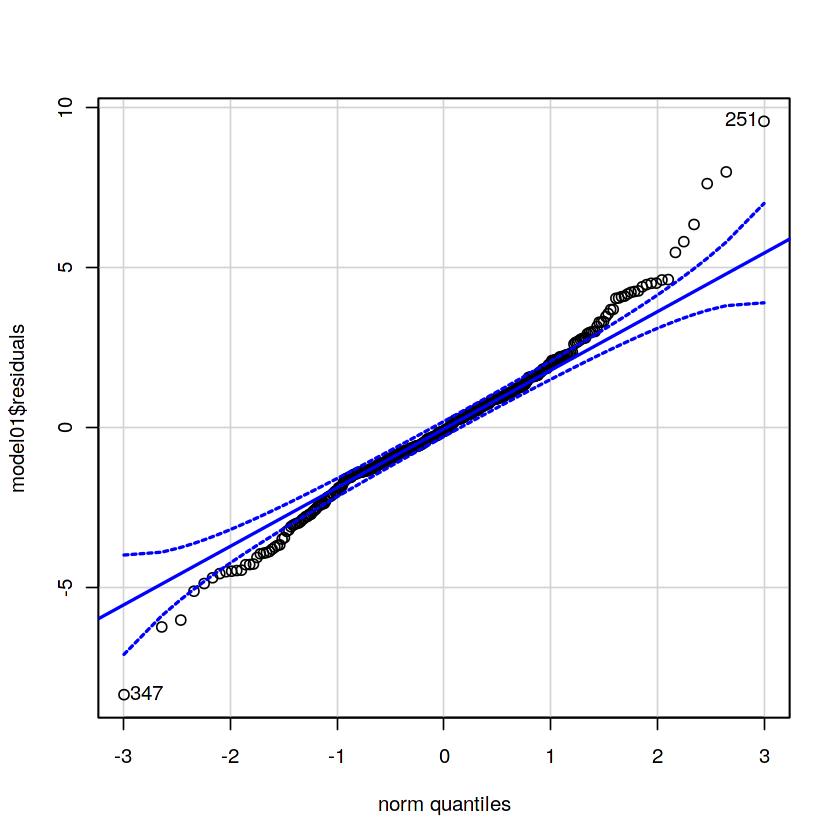

[1] 251 347

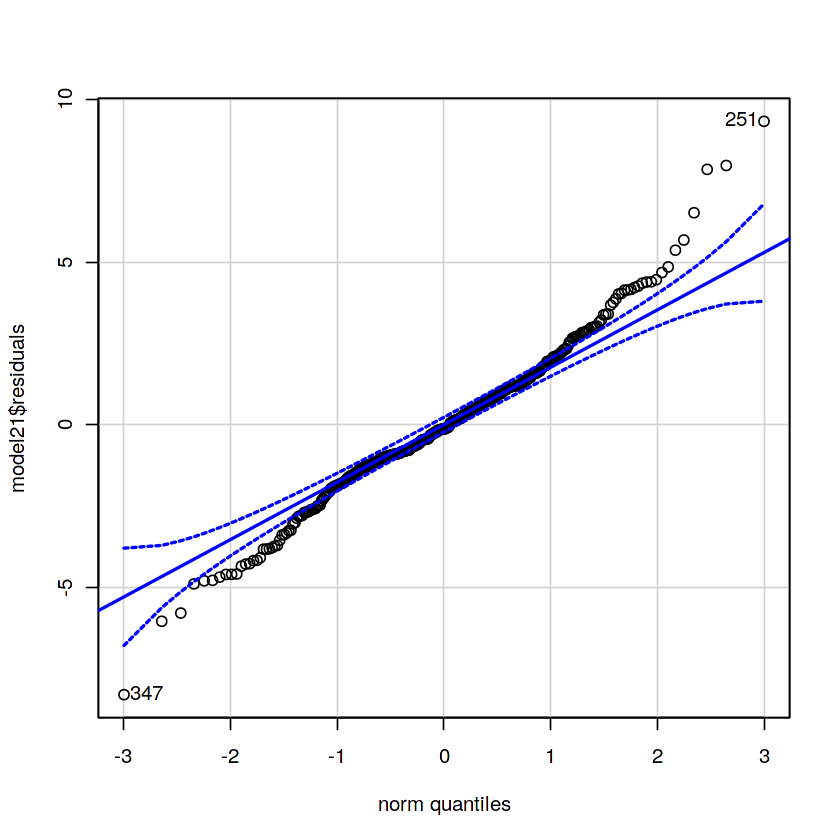

In [26]:
# Les critères d'information sont divergents, on regarde la normalité des résidus
model01 <- arima(x, order = c(0,0,1))
model21 <- arima(x, order = c(2,0,1))
cat("Modèle ARMA(0,1) :")
#On realise un test de Jarque Bera et de Shapiro
jarque.bera.test(model01$residuals)
shapiro.test(model01$residuals)
# H0: Normalité
# La normalité est rejetée
#QQ-plot:
qqPlot(model01$residuals)

cat("Modèle ARMA(2,1) :")
jarque.bera.test(model21$residuals)
shapiro.test(model21$residuals)
# La normalité est rejetée
#QQ-plot:
qqPlot(model21$residuals)

# Les 2 modèles donnent des résultats proches

In [27]:
# On s'intéresse aux R2 ajustés des deux modèles :
adjr2 <- function(model){
ss_res <- sum(model$residuals^2) #somme des r´esidus au carr´e
p <- length(model$model$phi) #r´ecup`ere l’ordre AR
q <- length(model$model$theta[model$model$theta!=0]) #r´ecup`ere l’ordre MA
ss_tot <- sum((x - mean(x))^2) #somme des observations de l’´echantillon au carr´e
n <- length(x) #taille de l’´echantillon
adj_r2 <- 1-(ss_res/(n-p-q-1))/(ss_tot/(n-1)) #r2 ajust´e
return(adj_r2)
}
cat("Modèle ARMA(0,1) : R2 = ",adjr2(model01),"\n")
cat("Modèle ARMA(2,1) : R2 = ",adjr2(model21))

# Le modèle ARMA(2,1) a un meilleur R2 ajusté

Modèle ARMA(0,1) : R2 =  0.2656797 


Modèle ARMA(2,1) : R2 =  0.2716548

Modèle ARMA(0,1) : RMSE =  129.2914 


Modèle ARMA(2,1) : RMSE =  125.9958

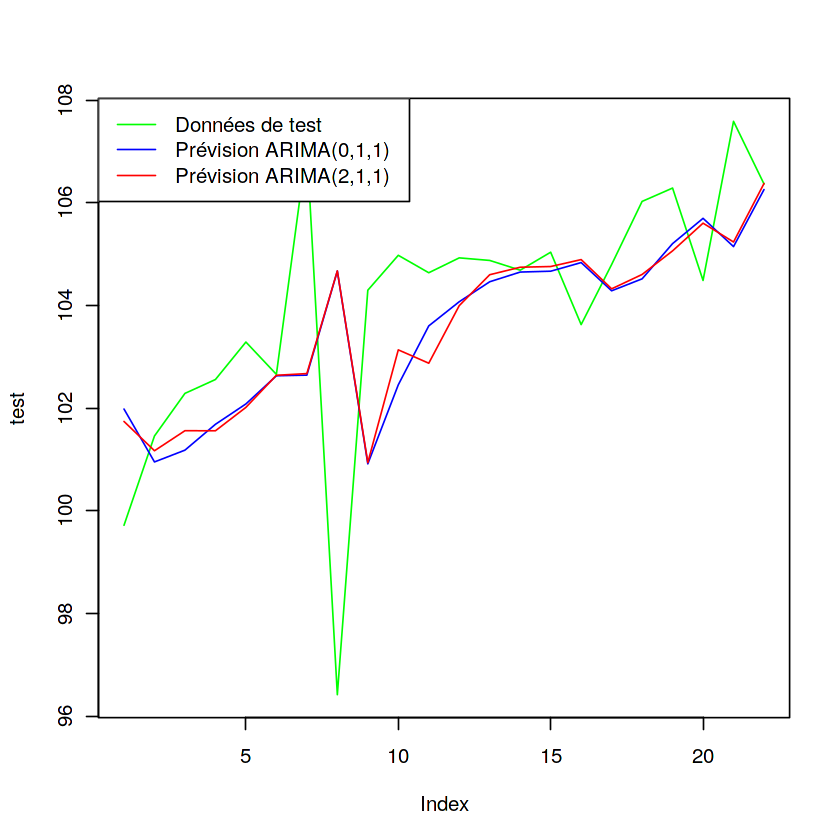

In [28]:
# Prévision sur un échantillon de test
n <- length(s)
train <- s[1:340]
test <- s[341:n]
model01 <- arima(train, order=c(0,1,1))
model21 <- arima(train, order=c(2,1,1))
testfit01 <- Arima(c(train,test), model=model01)
forecast01 <- fitted(testfit01)[341:n]
testfit21 <- Arima(c(train,test), model=model21)
forecast21 <- fitted(testfit21)[341:n]
cat("Modèle ARMA(0,1) : RMSE = ",sum((forecast01-test)^2),"\n")
cat("Modèle ARMA(2,1) : RMSE = ",sum((forecast21-test)^2))

plot(test, col="green",type="l")
lines(forecast01, col="blue")
lines(forecast21, col="red")
legend("topleft", legend = c("Données de test", "Prévision ARIMA(0,1,1)", "Prévision ARIMA(2,1,1)"),
       col = c("green", "blue","red"), lty = 1)

# Le modèle ARMA(2,1) donne une erreur inférieure au modèle ARMA(0,1) sur l'échantillon de test

In [29]:
#Chacun des deux modèles minimise un des deux criteres AIC et BIC, mais les critères des prevision et R2 ajusté ont montré que ARMA(2,1) est légèrement meilleur. On gardera donc ce modèle.

Coefficients : 


ar1        ar2        ma1  intercept 
-0.2311327 -0.1593465 -0.3796885  0.1001376

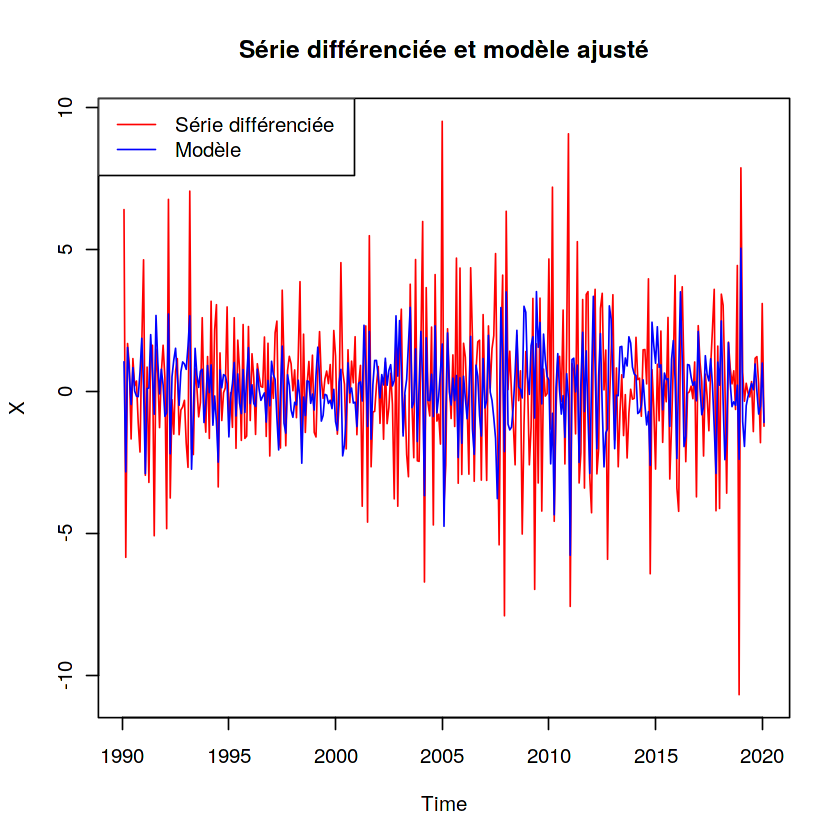

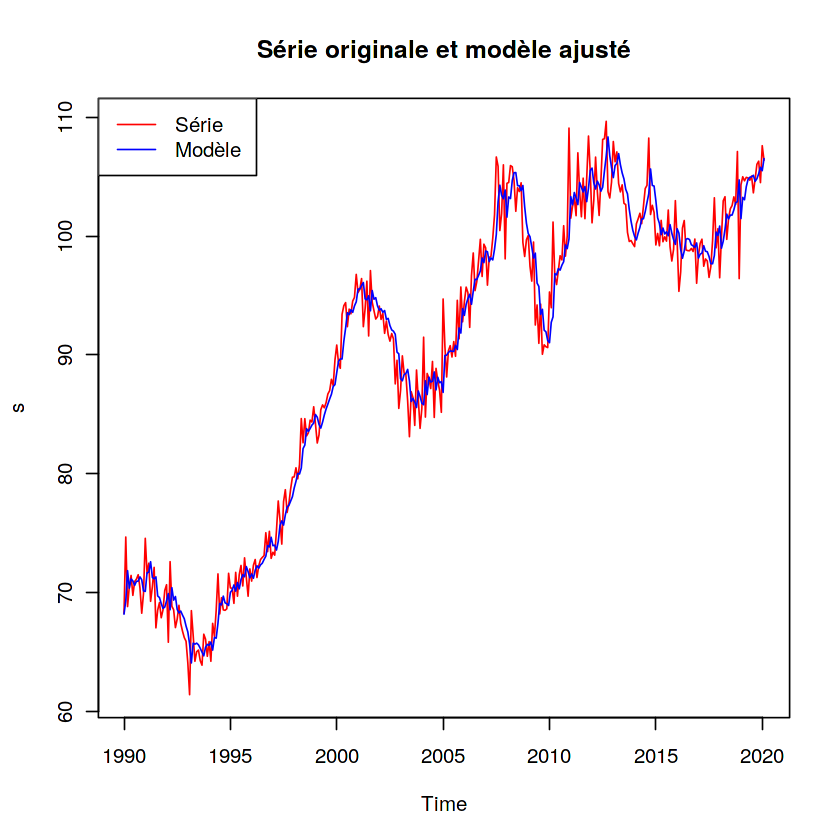

In [30]:
# Visualisation du modèle ARMA retenu
model_x <- Arima(x,order=c(2,0,1),include.constant=TRUE)
cat("Coefficients : \n")
model_x$coef # Coefficients du modèle
plot(model_x$x,col="red",type="l", main="Série différenciée et modèle ajusté", ylab="X")
lines(fitted(model_x),col="blue")
legend("topleft", legend = c("Série différenciée", "Modèle"),
       col = c("red", "blue"), lty = 1)
# On remarque que le modèle n'explique pas une grande partie de la variance (ce qui était prévisible par le R2 ~ 0.27), mais cela reste acceptable pour un modèle ARIMA série économétrique.

# Tracé de la série originale et du modèle
plot(s,col="red", type="l", main="Série originale et modèle ajusté")
model <- Arima(s,order=c(2,1,1), include.constant=TRUE)
lines(fitted(model),col="blue")
legend("topleft", legend = c("Série", "Modèle"),
       col = c("red", "blue"), lty = 1)

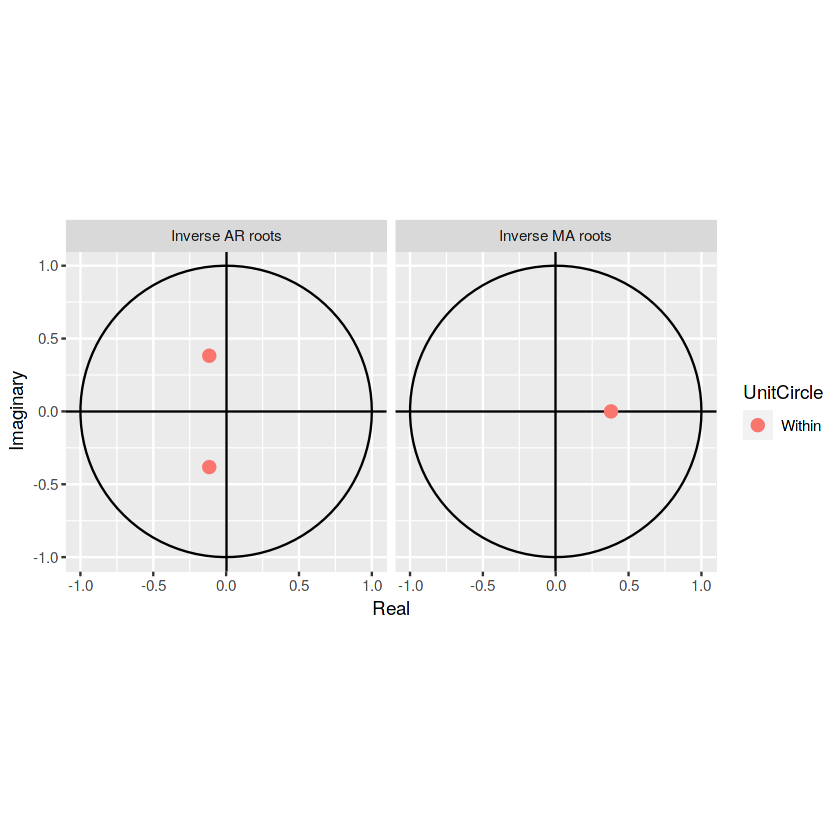

In [31]:
#On peut aussi vérifier les racines du modèle choisi :
autoplot(model)
# Elles sont bien à l'intérieur du cercle unité

## Prévision

In [32]:
####-- Partie 3 : Prévision --####
# On suppose dans cette partie que les résidus sont gaussiens

In [33]:
model <- Arima(x,order=c(2,0,1),include.constant=TRUE)

In [34]:
model$coef
alpha_0 <- as.numeric(model$coef[4])
phi_1 <- as.numeric(model$coef[1])
phi_2 <- as.numeric(model$coef[2])
psi_1 <- as.numeric(model$coef[3])
sigma2 <- as.numeric(model$sigma2)

ar1        ar2        ma1  intercept 
-0.2311327 -0.1593465 -0.3796885  0.1001376

In [35]:
# Prévisions de X_{T+1} et X_{T+2}
prev_T1 <- alpha_0 +phi_1*x[n-1] +phi_2*x[n-2]+ psi_1*as.numeric(model$residuals[n-1])
prev_T2 <- alpha_0 +phi_1*prev_T1 +phi_2*x[n-1]
cat("X(T+1) : ",prev_T1,"\n")
cat("X(T+2) : ",prev_T2)

X(T+1) :  -0.06147553 


X(T+2) :  0.3087493

In [36]:
# Intervalle de confiance univarié pour X_{T+1}
borne_sup_T1<- prev_T1 +1.96*sqrt(sigma2)
borne_inf_T1<- prev_T1-1.96*sqrt(sigma2)
# Intervalle de confiance univarié pour X_{T+2}
borne_sup_T2<- prev_T2 +1.96*sqrt(sigma2*(1+(phi_1+psi_1)^2))
borne_inf_T2<- prev_T2 -1.96*sqrt(sigma2*(1+(phi_1+psi_1)^2))
cat("IC(T+1) : [",borne_inf_T1,borne_sup_T1,"] \n")
cat("IC(T+2) : [",borne_inf_T2,borne_sup_T2,"] \n")

IC(T+1) : [ -4.501315 4.378364 ] 


IC(T+2) : [ -4.89383 5.511329 ] 


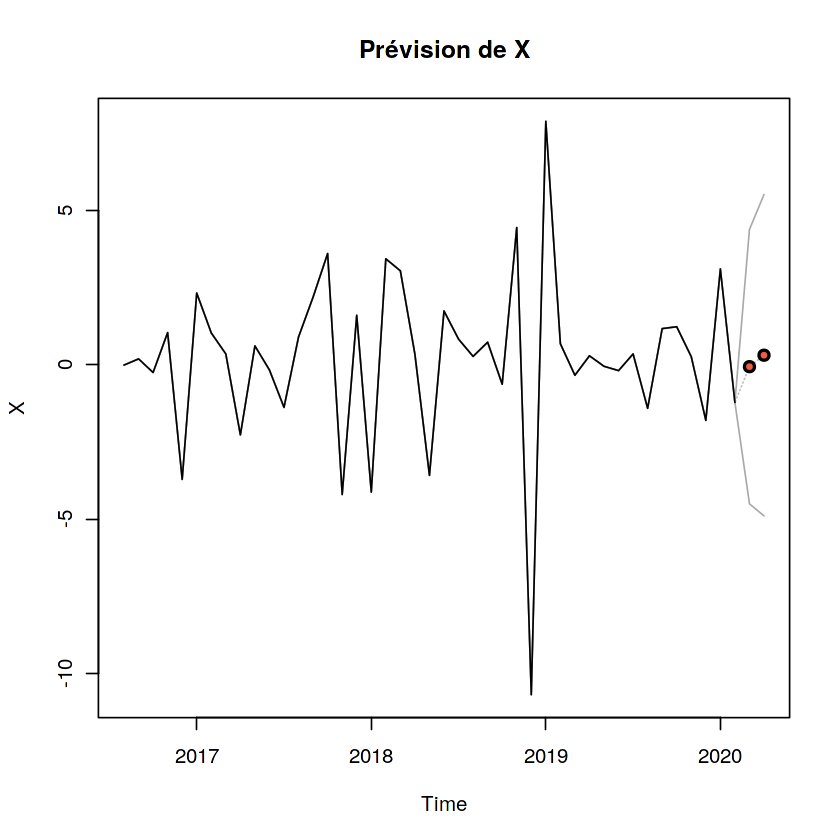

In [37]:
#Représentation graphique de l'intervalle de confiance (univarié) de X :
ts.plot(ts(c(x[320:n-1],borne_sup_T1, borne_sup_T2),start=2016+7/12,end=2020+3/12,frequency=12),type="l", col="darkgrey",main="Prévision de X", ylab="X")
lines(ts(c(x[320:n-1],borne_inf_T1, borne_inf_T2),start=2016+7/12,end=2020+3/12,frequency=12),type="l", col="darkgrey")
lines(ts(c(x[320:n-1],prev_T1, prev_T2),start=2016+7/12,end=2020+3/12,frequency=12),lty="dotted", col="grey")
lines(ts(x[320:n-1],start=2016+7/12,end=2020+1/12,frequency=12),type="l")
points(2020+2/12, prev_T1,bg='tomato2', pch=21, cex=1, lwd=2)
points(2020+3/12, prev_T2,bg='tomato2', pch=21, cex=1, lwd=2)

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.


Warning message:
“Removed 299 row(s) containing missing values (geom_path).”

IC(T+1) : [ -4.462131 4.417384 ] 


IC(T+2) : [ -4.863671 5.541297 ] 


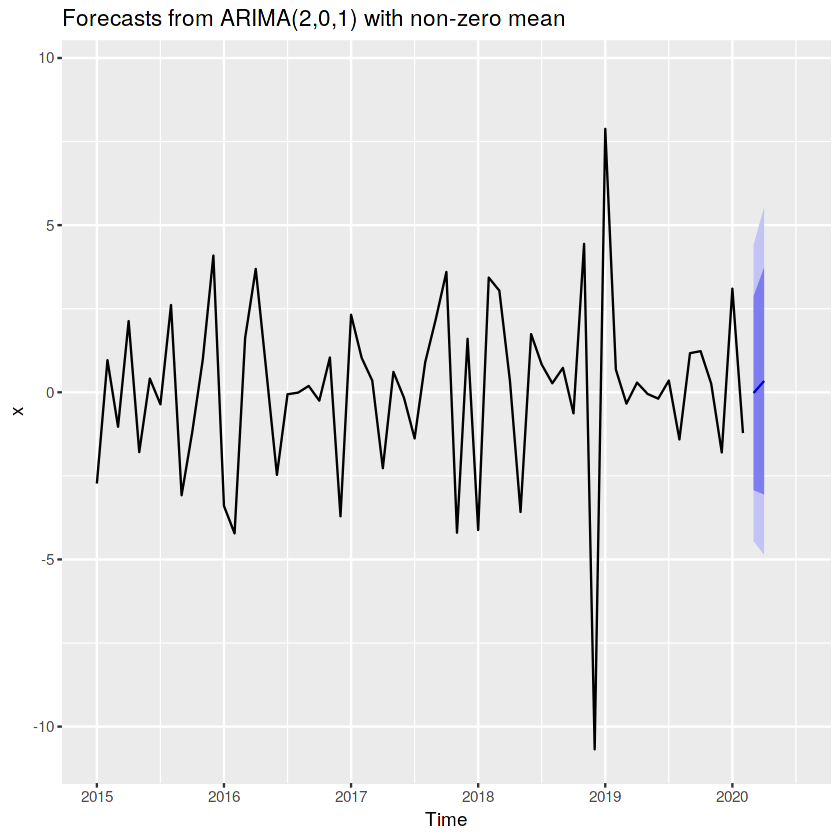

In [38]:
# On compare avec l'IC généré automatiquement par la librairie
autoplot(forecast(model,h=2),xlim=c(2015,2020.5))
cat("IC(T+1) : [",forecast(model,h=1)$lower[2], forecast(model,h=1)$upper[2],"] \n")
cat("IC(T+2) : [",forecast(model,h=2)$lower[4], forecast(model,h=2)$upper[4],"] \n")
# Résultats semblables à nos prévisions théoriques

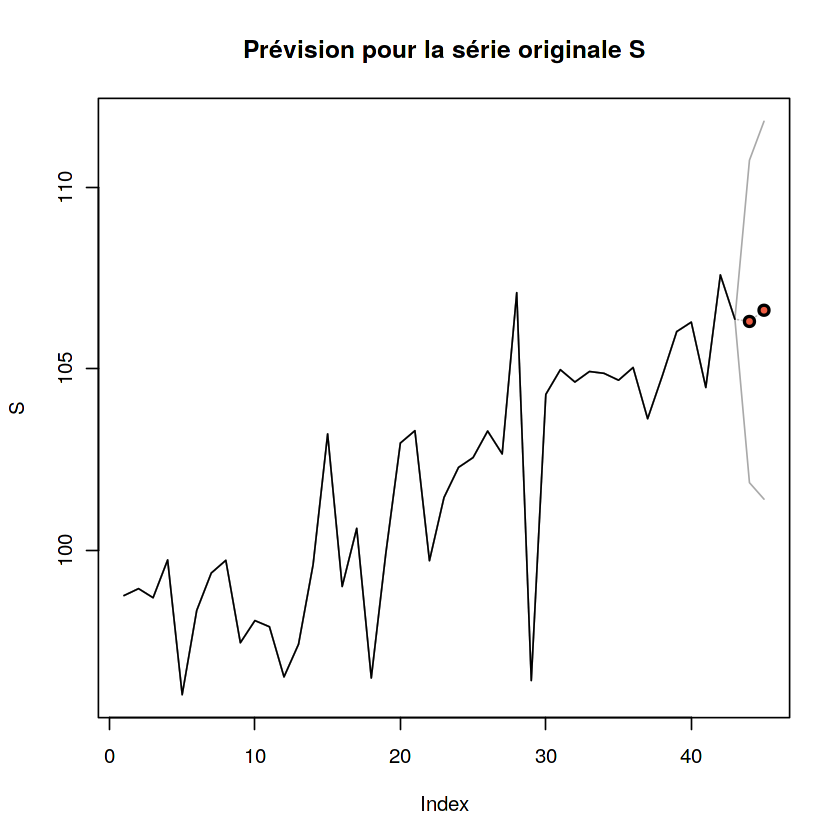

In [39]:
# Intervalle de confiance pour S :
prev_s_T1 <- s[n]+prev_T1
prev_s_T2 <- prev_s_T1+prev_T2
plot(c(s[320:n],borne_sup_T1+s[n], borne_sup_T2+prev_s_T1),type="l", col="darkgrey", main="Prévision pour la série originale S", ylab="S")
lines(c(s[320:n],borne_inf_T1+s[n], borne_inf_T2+prev_s_T1),type="l", col="darkgrey")
lines(c(s[320:n],prev_s_T1, prev_s_T2),lty="dotted", col="grey")
lines(s[320:n],type="l")
points(n-320+2, prev_s_T1,bg='tomato2', pch=21, cex=1, lwd=2)
points(n-320+3, prev_s_T2,bg='tomato2', pch=21, cex=1, lwd=2)

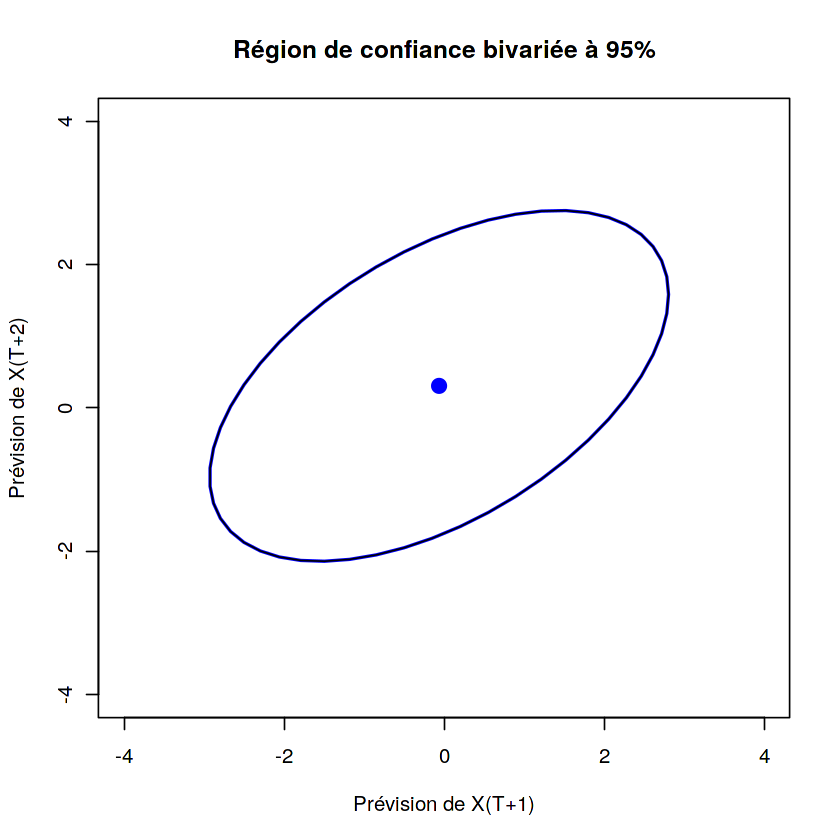

In [40]:
# Intervalle de confiance bivarié :
Sigma <- matrix(c(1, phi_1+psi_1,phi_1+psi_1,1+(phi_1+psi_1)^2), ncol=2)
inv_Sigma <- solve(Sigma)
plot(prev_T1,prev_T2,xlim=c(-4,4),ylim=c(-4,4), xlab="Prévision de X(T+1)", ylab="Prévision de X(T+2)", main="Région de confiance bivariée à 95%")
lines(car::ellipse(center = c(prev_T1,prev_T2), shape= inv_Sigma, radius=sqrt(qchisq(0.95,df=2)) ))